<a href="https://colab.research.google.com/github/aronsalinas96/tensorflow_basics/blob/main/08_Introduction_to_NLP_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (sequences text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq)

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5e43d940-5c00-0c6e-eca3-6f29cc7d4bd2)


## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset.

Original source: https://www.kaggle.com/c/nlp-getting-started

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2022-02-18 22:46:29--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c00::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-02-18 22:46:29 (156 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [2]:
import zipfile

filename = "nlp_getting_started.zip"
zip_ref = zipfile.ZipFile(filename, "r")
zip_ref.extractall()
zip_ref.close()

## Visualizing a text dataset

To visualize our text samples, we first have to read them in.

One way to do this is use pandas.

In [3]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
len(train_df), len(test_df)

(7613, 3263)

In [5]:
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text: \n{text}\n")

Target: 1 (real disaster)
Text: 
Still and Box alarm for the train derailment at 61st and Calumet struck out on the orders of 2-1-21. #ChicagoScanner

Target: 1 (real disaster)
Text: 
PHOTOS: The Rocky Fire has grown into California's most destructive wildfire this year. http://t.co/h9v4HoWtiP http://t.co/8IcSesHbj3

Target: 0 (not real disaster)
Text: 
That took way longer than I expected

Target: 0 (not real disaster)
Text: 
&gt;&gt; @GidiExclusixe Shock In Aba As Woman Delivers Û÷FacelessÛª Baby [Photo]: There was pandemonium... http://t.co/RGTYZbNKeo #BennyCapricon

Target: 0 (not real disaster)
Text: 
The year is 2065 and the national society of meme preservation has opened the first museum where memes and their origins are displaced



In [6]:
## Split data into training and validation sets
from sklearn.model_selection import train_test_split

In [7]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [8]:
train_sentences[:5], train_labels[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object), array([0, 0, 1, 0, 0]))

## Converting text into number

When dealing with a text problem, one of the first things you'll have to do before you can build a model is convert text to numbers.

There are few ways to do this, namely:

* **Tokenization** - direct mapping of token(word or character) to number.
* **Embedding** - create a matrix of feature vector for each token 

## Text vectorization (tokenization)

In [9]:
#Average number of words in training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [10]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, #automatically add <OOV> for others
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, #create groups of n-words?
                                    output_mode="int",
                                    output_sequence_length=max_length, #automatically gets bigger text
                                    pad_to_max_tokens=True) 

In [11]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [12]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a fire in my building!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3,  42,   4,  13, 630,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [13]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
top_5_words, bottom_5_words

(['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

### Creating an Embedding using an Embeding Layer

To make our embedding, we're going to use TensorFlow's embedding layer.

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token get represented by a vector 100 long.
* `input_length` = length of the sequences being passed to the embedding layer

In [14]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length
                             )

In [15]:
random_sentence = random.choice(train_sentences)
print(f"Original text: \n {random_sentence}\
        \n \n Embedded version: " )
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed # shape = 1, 15 (max_vocab_length), 128 (output dim) --> each of the 15 tokens (array of 15 element) is represented as a tensor of 128 elements

Original text: 
 U.S. record hurricane drought. http://t.co/fE9hIVfMxq        
 
 Embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02367349,  0.02425902, -0.00759047, ...,  0.02603301,
         -0.0114386 ,  0.04486388],
        [-0.01816767, -0.04035757, -0.03847962, ...,  0.00808502,
         -0.03157505,  0.02147502],
        [ 0.0467188 , -0.04001392,  0.04878275, ..., -0.0066929 ,
         -0.02143457, -0.03573713],
        ...,
        [-0.03863068,  0.01299653, -0.01967797, ..., -0.02551472,
          0.01405661,  0.02047993],
        [-0.03863068,  0.01299653, -0.01967797, ..., -0.02551472,
          0.01405661,  0.02047993],
        [-0.03863068,  0.01299653, -0.01967797, ..., -0.02551472,
          0.01405661,  0.02047993]]], dtype=float32)>

In [16]:
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.02367349,  0.02425902, -0.00759047,  0.00886009, -0.00985781,
         0.02341069,  0.02422616, -0.03525461, -0.00860698, -0.02079629,
        -0.03163538, -0.02749364, -0.00829739, -0.02960477,  0.00957511,
        -0.01837876, -0.00873283,  0.00943799,  0.01941237, -0.02583201,
        -0.0124128 ,  0.02578768,  0.04712143, -0.00579457, -0.01689576,
        -0.04153226, -0.01466769,  0.03188418,  0.00057939, -0.04476321,
         0.0092239 , -0.00566381, -0.02140899, -0.03800298,  0.0328587 ,
         0.02529925, -0.00297806, -0.00977977,  0.02539618, -0.03584402,
         0.00530189, -0.03991332,  0.04063131, -0.03147142,  0.00618009,
         0.00357632, -0.03440284,  0.01562845, -0.0449227 ,  0.03690637,
        -0.02911334, -0.00989274,  0.01802759, -0.03754824,  0.04574045,
        -0.03121992,  0.01336826, -0.02258899, -0.00277563, -0.02084532,
         0.02235073,  0.03096231,  0.02003194,  0.03140577,  0.02949995,
  

## Modelling a text dataset

It's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline model, not deep learning)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor (transfer learning)
* Model 7: Same as model 6 with 10% of training data

### Model 0: Getting a baseline 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 

model_0 = Pipeline([
          ("tfidf", TfidfVectorizer()),
          ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
baseline_score = model_0.score(val_sentences, val_labels)
round(baseline_score,4)*100

79.27

 ### Creating an evaluation function for our model experiments

In [36]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support 

def calculate_results(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": round(model_accuracy*100, 4),
                    "precision": round(model_precision*100, 4),
                    "recall": round(model_recall*100, 4),
                    "f1": round(model_f1*100, 4)}
  return model_results 

In [37]:
baseline_preds = model_0.predict(val_sentences)
baseline_results = calculate_results(y_true=val_labels, 
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.2651, 'f1': 78.6219, 'precision': 81.1139, 'recall': 79.2651}

## Model 1: A simple dense model

In [44]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [39]:
LOGS_DIR = "model_logs"

In [47]:
from tensorflow.keras import layers 
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [48]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [49]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=LOGS_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220218-230935
Epoch 1/5
215/215 [==============================] - 4s 5ms/step - loss: 0.6137 - accuracy: 0.6890 - val_loss: 0.5386 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4426 - accuracy: 0.8178 - val_loss: 0.4712 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3488 - accuracy: 0.8581 - val_loss: 0.4616 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2859 - accuracy: 0.8905 - val_loss: 0.4638 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2385 - accuracy: 0.9118 - val_loss: 0.4821 - val_accuracy: 0.7848


In [53]:
model_1_preds = tf.squeeze(tf.round(model_1.predict(val_sentences)))
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
baseline_results, model_1_results

({'accuracy': 79.2651, 'f1': 78.6219, 'precision': 81.1139, 'recall': 79.2651},
 {'accuracy': 78.4777, 'f1': 78.0969, 'precision': 79.197, 'recall': 78.4777})

## Visualizing learned embeddings


In [55]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [61]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [66]:
# # Code below is adapted from:
# https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk 
import io

# # Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

In [67]:
# # Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://projector.tensorflow.org/

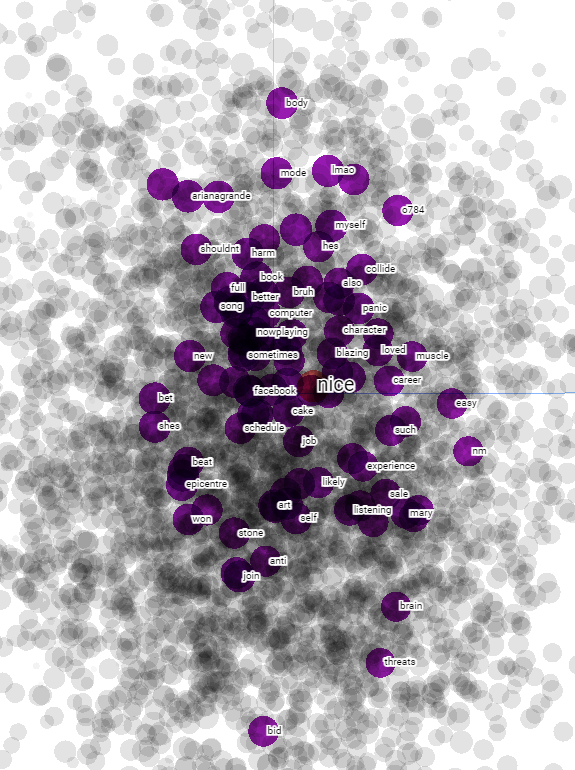

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.



### Model 2: LSTM

LSTM = long short term memory

An RNN typically looks like:

```
Input(text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [82]:
from tensorflow.keras import layers 
input = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) 
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [83]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [84]:
model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=LOGS_DIR,
                                                                     experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220218-234346
Epoch 1/5
215/215 [==============================] - 5s 10ms/step - loss: 0.1089 - accuracy: 0.9625 - val_loss: 0.9866 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0494 - accuracy: 0.9788 - val_loss: 1.2846 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0437 - accuracy: 0.9787 - val_loss: 1.2529 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0377 - accuracy: 0.9818 - val_loss: 1.5621 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0388 - accuracy: 0.9809 - val_loss: 1.4131 - val_accuracy: 0.7651


In [85]:
model_2_preds = tf.squeeze(tf.round(model_2.predict(val_sentences)))
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
baseline_results, model_1_results, model_2_results

({'accuracy': 79.2651, 'f1': 78.6219, 'precision': 81.1139, 'recall': 79.2651},
 {'accuracy': 78.4777, 'f1': 78.0969, 'precision': 79.197, 'recall': 78.4777},
 {'accuracy': 76.5092, 'f1': 76.1707, 'precision': 76.9239, 'recall': 76.5092})

### Model 3: GRU

Gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters

In [92]:
from tensorflow.keras import layers
input = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers
#x = layers.LSTM(64)(x)
#x = layers.GRU(64)(x)
#x = layers.Dense(64, activation="sigmoid")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [93]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [94]:
model_3_history = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=LOGS_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220218-235014
Epoch 1/5
215/215 [==============================] - 3s 7ms/step - loss: 0.1257 - accuracy: 0.9511 - val_loss: 0.9811 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0556 - accuracy: 0.9778 - val_loss: 0.9882 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0476 - accuracy: 0.9784 - val_loss: 1.0483 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0400 - accuracy: 0.9806 - val_loss: 1.1332 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0373 - accuracy: 0.9806 - val_loss: 1.3690 - val_accuracy: 0.7730


In [95]:
model_3_preds = tf.squeeze(tf.round(model_3.predict(val_sentences)))
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
baseline_results, model_1_results, model_2_results, model_3_results

({'accuracy': 79.2651, 'f1': 78.6219, 'precision': 81.1139, 'recall': 79.2651},
 {'accuracy': 78.4777, 'f1': 78.0969, 'precision': 79.197, 'recall': 78.4777},
 {'accuracy': 76.5092, 'f1': 76.1707, 'precision': 76.9239, 'recall': 76.5092},
 {'accuracy': 77.2966, 'f1': 77.0151, 'precision': 77.6321, 'recall': 77.2966})

### Model 4: Bidirectional RNN

Normal RNN's go from left to right, however, a bidirectional RNN goes from left to right as well as right to left.

In [111]:
from tensorflow.keras import layers
imputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [112]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [113]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [114]:
model_4_history = model_4.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=LOGS_DIR,
                                                                     experiment_name="model_4_bidirecctional")])

Saving TensorBoard log files to: model_logs/model_4_bidirecctional/20220219-000105
Epoch 1/5
215/215 [==============================] - 5s 10ms/step - loss: 0.0835 - accuracy: 0.9765 - val_loss: 1.2484 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0358 - accuracy: 0.9818 - val_loss: 1.2547 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0320 - accuracy: 0.9848 - val_loss: 1.4507 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0319 - accuracy: 0.9844 - val_loss: 1.5767 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0292 - accuracy: 0.9832 - val_loss: 1.5701 - val_accuracy: 0.7651


In [115]:
model_4_preds = tf.squeeze(tf.round(model_4.predict(val_sentences)))
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
baseline_results, model_1_results, model_2_results, model_3_results, model_4_results

({'accuracy': 79.2651, 'f1': 78.6219, 'precision': 81.1139, 'recall': 79.2651},
 {'accuracy': 78.4777, 'f1': 78.0969, 'precision': 79.197, 'recall': 78.4777},
 {'accuracy': 76.5092, 'f1': 76.1707, 'precision': 76.9239, 'recall': 76.5092},
 {'accuracy': 77.2966, 'f1': 77.0151, 'precision': 77.6321, 'recall': 77.2966},
 {'accuracy': 76.5092, 'f1': 76.4252, 'precision': 76.4824, 'recall': 76.5092})

## Convolutional Neural Networks for Text

### Model 5: Conv1D

In [119]:
from tensorflow.keras import layers 
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, 
                  kernel_size=5, 
                  strides=1, 
                  activation="relu", 
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [120]:
model_5_history = model_5.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=LOGS_DIR,
                                                                     experiment_name="model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20220219-000801
Epoch 1/5
215/215 [==============================] - 8s 6ms/step - loss: 0.0991 - accuracy: 0.9675 - val_loss: 1.0391 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0606 - accuracy: 0.9790 - val_loss: 1.1829 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0517 - accuracy: 0.9801 - val_loss: 1.2639 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0475 - accuracy: 0.9804 - val_loss: 1.2700 - val_accuracy: 0.7520
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0441 - accuracy: 0.9810 - val_loss: 1.3030 - val_accuracy: 0.7520


In [123]:
model_5_preds = tf.squeeze(tf.round(model_5.predict(val_sentences)))
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
baseline_results, model_1_results, model_2_results, model_3_results, model_4_results, model_5_results

({'accuracy': 79.2651, 'f1': 78.6219, 'precision': 81.1139, 'recall': 79.2651},
 {'accuracy': 78.4777, 'f1': 78.0969, 'precision': 79.197, 'recall': 78.4777},
 {'accuracy': 76.5092, 'f1': 76.1707, 'precision': 76.9239, 'recall': 76.5092},
 {'accuracy': 77.2966, 'f1': 77.0151, 'precision': 77.6321, 'recall': 77.2966},
 {'accuracy': 76.5092, 'f1': 76.4252, 'precision': 76.4824, 'recall': 76.5092},
 {'accuracy': 75.1969, 'f1': 75.1603, 'precision': 75.1553, 'recall': 75.1969})

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [124]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [125]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                        input_shape=[],
                                        dtype=tf.string, 
                                        trainable=False,
                                        name="USE")

In [131]:
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation="relu"),
                               layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [127]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               147354880 
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 147,355,393
Trainable params: 513
Non-trainable params: 147,354,880
_________________________________________________________________


In [132]:
model_6_history = model_6.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=LOGS_DIR,
                                                                     experiment_name="model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20220219-002202
Epoch 1/5
215/215 [==============================] - 24s 65ms/step - loss: 0.4982 - accuracy: 0.7996 - val_loss: 0.4260 - val_accuracy: 0.8255
Epoch 2/5
215/215 [==============================] - 9s 40ms/step - loss: 0.4004 - accuracy: 0.8267 - val_loss: 0.4216 - val_accuracy: 0.8228
Epoch 3/5
215/215 [==============================] - 9s 43ms/step - loss: 0.3832 - accuracy: 0.8329 - val_loss: 0.4208 - val_accuracy: 0.8281
Epoch 4/5
215/215 [==============================] - 9s 40ms/step - loss: 0.3732 - accuracy: 0.8370 - val_loss: 0.4195 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 9s 42ms/step - loss: 0.3645 - accuracy: 0.8422 - val_loss: 0.4184 - val_accuracy: 0.8150


In [133]:
model_6_preds = tf.squeeze(tf.round(model_6.predict(val_sentences)))
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
baseline_results, model_1_results, model_2_results, model_3_results, model_4_results, model_5_results, model_6_results

({'accuracy': 79.2651, 'f1': 78.6219, 'precision': 81.1139, 'recall': 79.2651},
 {'accuracy': 78.4777, 'f1': 78.0969, 'precision': 79.197, 'recall': 78.4777},
 {'accuracy': 76.5092, 'f1': 76.1707, 'precision': 76.9239, 'recall': 76.5092},
 {'accuracy': 77.2966, 'f1': 77.0151, 'precision': 77.6321, 'recall': 77.2966},
 {'accuracy': 76.5092, 'f1': 76.4252, 'precision': 76.4824, 'recall': 76.5092},
 {'accuracy': 75.1969, 'f1': 75.1603, 'precision': 75.1553, 'recall': 75.1969},
 {'accuracy': 81.4961, 'f1': 81.3814, 'precision': 81.6185, 'recall': 81.4961})

## Model 7: TF Hub Pretrained USE but with 10% of training data

In [145]:
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [146]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [143]:
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               147354880 
                                                                 
 dense_19 (Dense)            (None, 64)                32832     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 147,387,777
Trainable params: 32,897
Non-trainable params: 147,354,880
_________________________________________________________________


In [147]:
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=LOGS_DIR,
                                                                     experiment_name="model_7_USE_10_percent")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent/20220219-005405
Epoch 1/5
22/22 [==============================] - 34s 393ms/step - loss: 0.6695 - accuracy: 0.7255 - val_loss: 0.6437 - val_accuracy: 0.7664
Epoch 2/5
22/22 [==============================] - 2s 100ms/step - loss: 0.5983 - accuracy: 0.8175 - val_loss: 0.5811 - val_accuracy: 0.7822
Epoch 3/5
22/22 [==============================] - 2s 79ms/step - loss: 0.5207 - accuracy: 0.8292 - val_loss: 0.5216 - val_accuracy: 0.8005
Epoch 4/5
22/22 [==============================] - 2s 77ms/step - loss: 0.4594 - accuracy: 0.8292 - val_loss: 0.4839 - val_accuracy: 0.8031
Epoch 5/5
22/22 [==============================] - 2s 78ms/step - loss: 0.4173 - accuracy: 0.8307 - val_loss: 0.4658 - val_accuracy: 0.7992


In [148]:
model_7_preds = tf.squeeze(tf.round(model_7.predict(val_sentences)))
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
baseline_results, model_1_results, model_2_results, model_3_results, model_4_results, model_5_results, model_6_results, model_7_results

({'accuracy': 79.2651, 'f1': 78.6219, 'precision': 81.1139, 'recall': 79.2651},
 {'accuracy': 78.4777, 'f1': 78.0969, 'precision': 79.197, 'recall': 78.4777},
 {'accuracy': 76.5092, 'f1': 76.1707, 'precision': 76.9239, 'recall': 76.5092},
 {'accuracy': 77.2966, 'f1': 77.0151, 'precision': 77.6321, 'recall': 77.2966},
 {'accuracy': 76.5092, 'f1': 76.4252, 'precision': 76.4824, 'recall': 76.5092},
 {'accuracy': 75.1969, 'f1': 75.1603, 'precision': 75.1553, 'recall': 75.1969},
 {'accuracy': 81.4961, 'f1': 81.3814, 'precision': 81.6185, 'recall': 81.4961},
 {'accuracy': 79.9213, 'f1': 79.6723, 'precision': 80.355, 'recall': 79.9213})

## Comparing the performance of each of our models

In [150]:
all_model_results = pd.DataFrame({"0_baseline":baseline_results,
                                  "model_1_simple_dense":model_1_results,
                                  "model_2_LSTM":model_2_results,
                                  "model_3_GRU":model_3_results,
                                  "model_4_Bidirectional":model_4_results,
                                  "model_5_Conv1d":model_5_results,
                                  "model_6_USE":model_6_results,
                                  "model_7_USE_10_percent":model_7_results})
D.transpose()

,accuracy,precision,recall,f1
0_baseline,79.2651,81.1139,79.2651,78.6219
model_1_simple_dense,78.4777,79.1970,78.4777,78.0969
model_2_LSTM,76.5092,76.9239,76.5092,76.1707
model_3_GRU,77.2966,77.6321,77.2966,77.0151
model_4_Bidirectional,76.5092,76.4824,76.5092,76.4252
model_5_Conv1d,75.1969,75.1553,75.1969,75.1603
model_6_USE,81.4961,81.6185,81.4961,81.3814
model_7_USE_10_percent,79.9213,80.3550,79.9213,79.6723


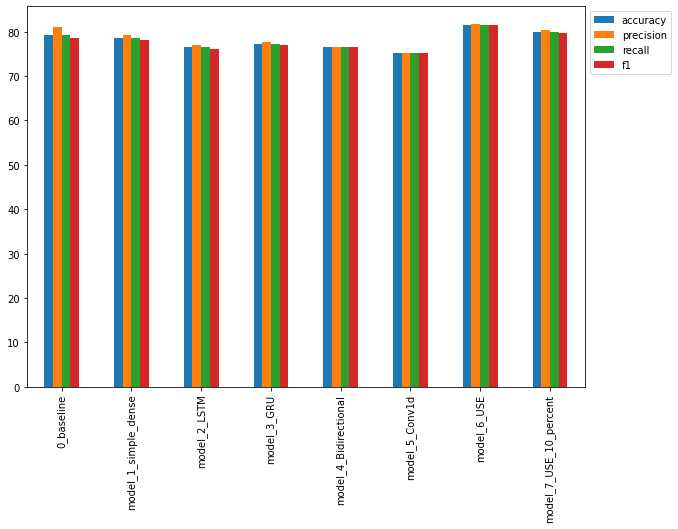

In [153]:
all_model_results.transpose().plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

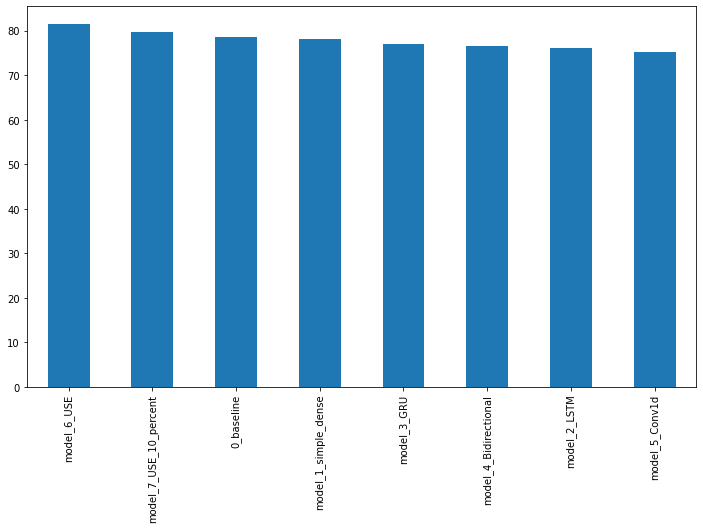

In [158]:
all_model_results.transpose().sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(12, 7))

## Saving and loading a trained model

In [159]:
model_6.save("model_6.h5")

In [161]:
import tensorflow_hub as hub 
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [162]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 5s 37ms/step - loss: 0.4184 - accuracy: 0.8150


[0.41843876242637634, 0.8149606585502625]